In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for dealing with null values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Data Pre-processing Libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

# Modelling Libraries
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Evaluation & CV Libraries
from sklearn.metrics import precision_score,accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import warnings
import optuna
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
from tqdm import tqdm

# Load the data

In [2]:
# sample_submission csv file
ss = pd.read_csv('sample_submission.csv')
ss

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [3]:
print("Number of nunique Id's: {:.1f}".format(ss['PassengerId'].nunique()))
print("Number of Transported: ", ss['Transported'].value_counts(normalize=True))

Number of nunique Id's: 4277.0
Number of Transported:  False    1.0
Name: Transported, dtype: float64


In [4]:
# train and test csv files
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## File and Data Field Descriptions

    PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    
    HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    
    CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    
    Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    
    Destination - The planet the passenger will be debarking to.
    
    Age - The age of the passenger.
    
    VIP - Whether the passenger has paid for special VIP service during the voyage.
    
    RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    
    Name - The first and last names of the passenger.
    
    Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [7]:
# merge test.csv and sample_submission.csv  on PassengerId
df1 = pd.merge(test, ss, how='inner', on='PassengerId')
df1['train_test'] = 'test'

In [8]:
# concatenate new df1 and train.csv
train['train_test'] = 'train'
df = pd.concat([train,df1]).reset_index(drop=True)
df.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,train_test
3174,3422_02,Europa,True,E/209/P,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Atonib Crakete,True,train
4919,5246_02,Earth,False,F/1070/P,TRAPPIST-1e,NaN,False,0.0,13.0,643.0,47.0,0.0,Jodia Drakeekss,True,train
7544,8064_02,Mars,False,E/534/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Elos Erte,True,train
3076,3318_03,Europa,False,B/123/S,TRAPPIST-1e,11.0,False,0.0,0.0,0.0,0.0,0.0,Altara Openduave,True,train
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,train


In [9]:
# checking null values in df
df.isnull().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
Transported       0
train_test        0
dtype: int64

In [10]:
# Individual Name for each passenger, this information wont be helpful in future calculation. I drop this column:
df.drop('Name', axis=1, inplace=True)

## Dealing with missing values

In [11]:
# when people are in Cryosleep don't pay for luxury amenities
df[df['CryoSleep']==True].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4467.000000,4488.0,4472.0,4450.0,4474.0,4490.0
mean,27.510857,0.0,0.0,0.0,0.0,0.0
std,14.887864,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0
25%,18.000000,0.0,0.0,0.0,0.0,0.0
50%,26.000000,0.0,0.0,0.0,0.0,0.0
75%,37.000000,0.0,0.0,0.0,0.0,0.0
max,78.000000,0.0,0.0,0.0,0.0,0.0


In [12]:
df[df['CryoSleep']==False].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,7926.000000,7912.000000,7902.000000,7914.000000,7909.000000,7910.000000
mean,29.484229,349.153185,709.269046,274.165782,482.310532,481.595196
std,14.030870,781.652731,1945.240029,723.914453,1375.663790,1453.900973
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,3.000000,6.000000,2.000000,8.000000,3.000000
75%,38.000000,399.000000,539.750000,250.500000,364.000000,342.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [13]:
df[df['CryoSleep']==True].isnull().sum()

PassengerId       0
HomePlanet      103
CryoSleep         0
Cabin           119
Destination      80
Age             114
VIP             104
RoomService      93
FoodCourt       109
ShoppingMall    131
Spa             107
VRDeck           91
Transported       0
train_test        0
dtype: int64

In [14]:
# changing if cryoleep is true, all the luxury amenities to 0
df["RoomService"] = np.where(((df["CryoSleep"] == True) & (df["RoomService"].isnull())), 0, df["RoomService"])
df["FoodCourt"] = np.where(((df["CryoSleep"] == True) & (df["FoodCourt"].isnull())), 0, df["FoodCourt"])
df["ShoppingMall"] = np.where(((df["CryoSleep"] == True) & (df["ShoppingMall"].isnull())), 0, df["ShoppingMall"])
df["Spa"] = np.where(((df["CryoSleep"] == True) & (df["Spa"].isnull())), 0, df["Spa"])
df["VRDeck"] = np.where(((df["CryoSleep"] == True) & (df["VRDeck"].isnull())), 0, df["VRDeck"])
df[df['CryoSleep']==True].isnull().sum()

PassengerId       0
HomePlanet      103
CryoSleep         0
Cabin           119
Destination      80
Age             114
VIP             104
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
train_test        0
dtype: int64

In [15]:
# split Cabin column to 3 new columns deck/num/side, where side can be either P for Port or S for Starboard.
df[['Cabin_deck', 'Cabin_no', 'Cabin_side']] = df['Cabin'].str.split('/', expand=True)
df[['Passenger_no', 'Passenger_group']] = df['PassengerId'].str.split('_', expand=True)

In [16]:
df_pivot = pd.pivot_table(df, index='Cabin_deck', columns='HomePlanet', values='Cabin' , aggfunc='count')
df_pivot

HomePlanet,Earth,Europa,Mars
Cabin_deck,,,
A,NaN,346.0,NaN
B,NaN,1124.0,NaN
C,NaN,1081.0,NaN
D,NaN,296.0,406.0
E,583.0,197.0,508.0
F,2426.0,NaN,1713.0
G,3700.0,NaN,NaN
T,NaN,10.0,NaN


    looks like A, B, C and T cabins were for people travelling from Europa, G only from Earth

In [17]:
# fill Nan's on HomePlanet, according to Cabin_deck
df["HomePlanet"] = np.where(((df["Cabin_deck"] == 'G') & (df["HomePlanet"].isnull())), 'Earth', df["HomePlanet"])
df["HomePlanet"] = np.where(((df["Cabin_deck"] == 'A') & (df["HomePlanet"].isnull())), 'Europa', df["HomePlanet"])
df["HomePlanet"] = np.where(((df["Cabin_deck"] == 'B') & (df["HomePlanet"].isnull())), 'Europa', df["HomePlanet"])
df["HomePlanet"] = np.where(((df["Cabin_deck"] == 'C') & (df["HomePlanet"].isnull())), 'Europa', df["HomePlanet"])
df["HomePlanet"] = np.where(((df["Cabin_deck"] == 'T') & (df["HomePlanet"].isnull())), 'Europa', df["HomePlanet"])

In [18]:
# drop columns that are not helpful
df.drop(['PassengerId', 'Cabin', 'Cabin_no', 'Passenger_no'], axis=1, inplace=True)

In [19]:
# for the rest missing values I'll use Iterative Imputer
# Transform categorical data with values to digits
df['HomePlanet'] = df['HomePlanet'].replace({'Mars': 1, 'Europa':2, 'Earth':3})
df['Destination'] = df['Destination'].replace({'55 Cancri e': 1, 'TRAPPIST-1e':2, 'PSO J318.5-22':3})
df['Cabin_deck'] = df['Cabin_deck'].replace({'A': 1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8})
df['Cabin_side'] = df['Cabin_side'].replace({'P': 1, 'S':2})
df['train_test'] = df['train_test'].replace({'test': 0, 'train':1})

In [20]:
imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed, columns=df.columns)

In [21]:
df_imputed.isnull().sum()

HomePlanet         0
CryoSleep          0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported        0
train_test         0
Cabin_deck         0
Cabin_side         0
Passenger_group    0
dtype: int64

In [22]:
# changing digits again to categories
df_imputed["HomePlanet"] = pd.cut( x=df_imputed["HomePlanet"], bins=[-2, 1.5, 2.5, np.inf],
                                  labels=['Mars', 'Europa', 'Earth'])
df_imputed["Destination"] = pd.cut( x=df_imputed["Destination"], bins=[-2, 1.5, 2.5, np.inf],
                                  labels=['55 Cancri e', 'TRAPPIST-1e', 'PSO J318.5-22'])
df_imputed["CryoSleep"] = pd.cut( x=df_imputed["CryoSleep"], bins=[-2, 0.5, np.inf],
                                  labels=['False', 'True'])
df_imputed["VIP"] = pd.cut( x=df_imputed["VIP"], bins=[-1, 0.5, np.inf],
                                  labels=['False', 'True'])
df_imputed["Cabin_side"] = pd.cut( x=df_imputed["Cabin_side"], bins=[0, 1.5, np.inf],
                                  labels=['Port', 'Starboard'])
df_imputed["Cabin_deck"] = pd.cut( x=df_imputed["Cabin_deck"], bins=[0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
                                  labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
round(df_imputed,0)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,train_test,Cabin_deck,Cabin_side,Passenger_group
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B,Port,1.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1.0,1.0,F,Starboard,1.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0.0,1.0,A,Starboard,1.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0.0,1.0,A,Starboard,2.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1.0,1.0,F,Starboard,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G,Starboard,2.0
12966,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,0.0,0.0,F,Starboard,1.0
12967,Mars,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,Port,1.0
12968,Europa,False,TRAPPIST-1e,33.0,False,0.0,2680.0,0.0,0.0,523.0,0.0,0.0,D,Port,1.0


In [23]:
# create again train set
train = df_imputed[df_imputed['train_test'] == 1]
train.drop(['train_test'], axis=1, inplace=True)
train.shape

C:\Users\HP\AppData\Local\Temp\ipykernel_18308\860867335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['train_test'], axis=1, inplace=True)


(8693, 14)

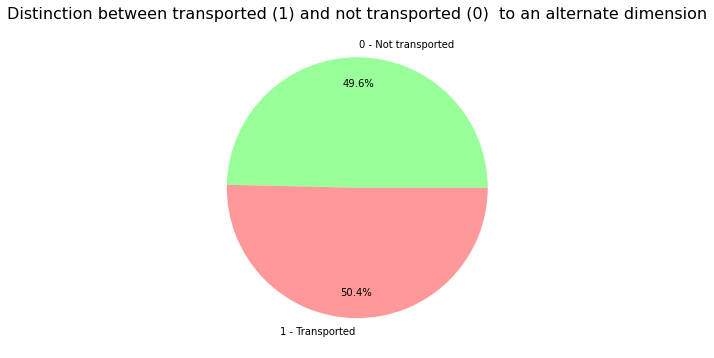

In [24]:
# create pie chart
clas = dict(train.groupby('Transported')['Transported'].count())
labels = ['0 - Not transported', '1 - Transported']
colors = ['#99ff99', '#ff9999']
values = clas.values()
plt.figure(figsize=(6,6))
plt.pie(data=df, x=values, labels=labels, autopct = '%1.1f%%', pctdistance=0.8, colors=colors)
plt.title('Distinction between transported (1) and not transported (0)  to an alternate dimension', fontsize=16)
plt.show()

    the dataset is balanced (almost the same values for transported and non-transported)

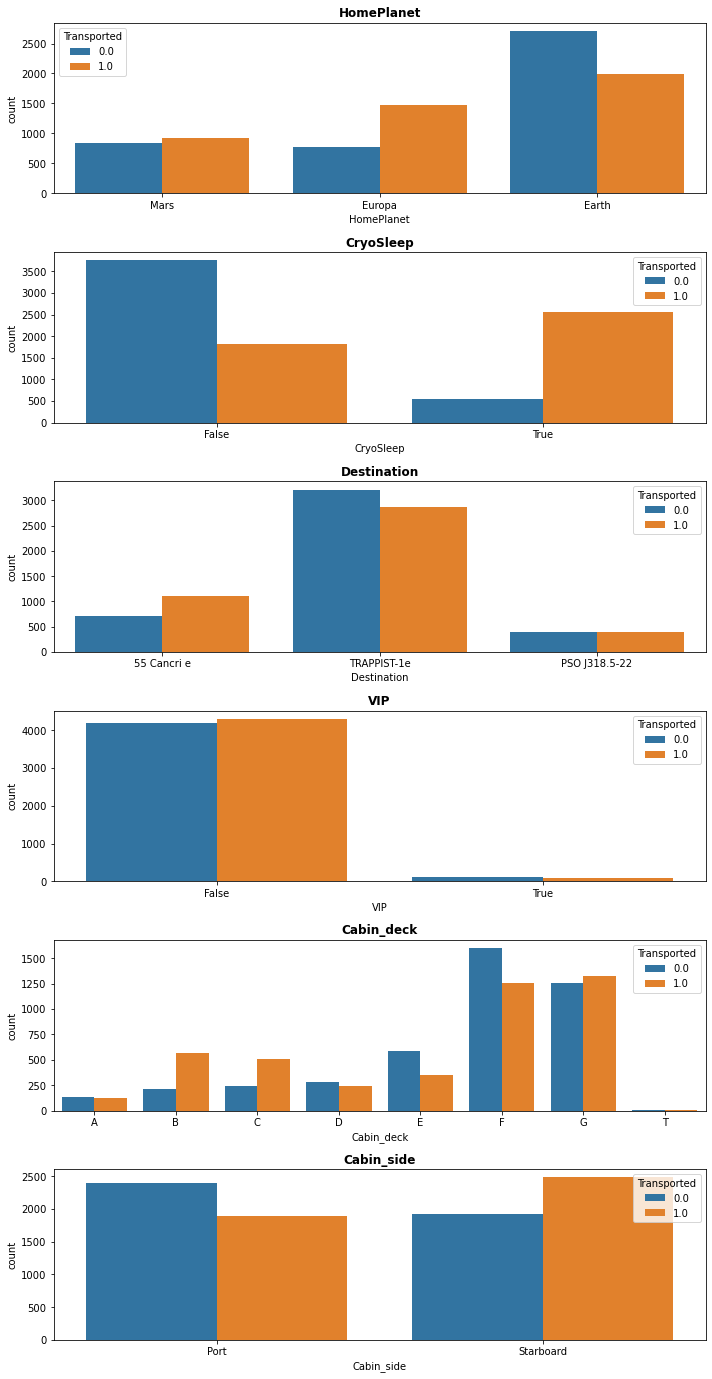

In [25]:
fig=plt.figure(figsize=(10, 22))
for i, var_name in enumerate(['HomePlanet','CryoSleep','Destination','VIP', 'Cabin_deck', 'Cabin_side']):
    ax=fig.add_subplot(7, 1, i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name, fontsize=12, fontweight='bold')
fig.tight_layout()
plt.show()

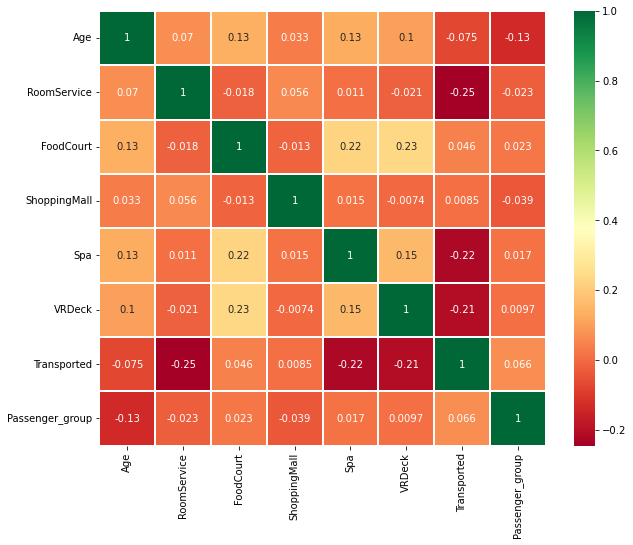

In [26]:
# chcecking the correlations between variables
corr=train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.05)
plt.show()

In [27]:
# create again test set
test = df_imputed[df_imputed['train_test'] == 0]
test.drop(['train_test'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_18308\3971200288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['train_test'], axis=1, inplace=True)


## Data preprocessing

In [29]:
# one hot encoding
train_ohe = pd.get_dummies(data=train, columns=['HomePlanet', 'CryoSleep', 'Destination', 
                                                'VIP', 'Cabin_deck', 'Cabin_side'])
test_ohe = pd.get_dummies(data=test, columns=['HomePlanet', 'CryoSleep', 'Destination', 
                                                'VIP', 'Cabin_deck', 'Cabin_side'])

## Standardizing The Data

In [30]:
X_train = train_ohe.drop('Transported',axis=1)
y_train = train_ohe['Transported']
X_test = test_ohe.drop('Transported',axis=1)
y_test = test_ohe['Transported']

In [31]:
# I'll be working on train set
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=42)

print("X_train1 : " + str(X_train1.shape))
print("y_train1 : " + str(y_train1.shape))
print("X_validation : " + str(X_val.shape))
print("y_validation : " + str(y_val.shape))

X_train1 : (6954, 27)
y_train1 : (6954,)
X_validation : (1739, 27)
y_validation : (1739,)


In [32]:
scaler = StandardScaler()
scaler.fit(X_train1)
X_train1 = scaler.transform(X_train1)
X_val = scaler.transform(X_val)

## Modelling

In [33]:
warnings.filterwarnings('ignore')

In [ ]:
models =[("CAT", CatBoostClassifier(random_state=42)), ("LGBM", LGBMClassifier(random_state=42)),
         ("XGB", XGBClassifier(random_state=42))]

results = []
names = []
finalResults = []

for name,model in models:
    model.fit(X_train1, y_train1)
    model_results = model.predict(X_val)
    score = accuracy_score(y_val, model_results)
    results.append(score)
    names.append(name)
    finalResults.append((name,score))
    
finalResults.sort(key=lambda k:k[1],reverse=True)

In [57]:
finalResults  # Accuracy score for validation set

[('LGBM', 0.8108108108108109),
 ('XGB', 0.8096607245543416),
 ('CAT', 0.8067855089131685)]

## Hyperparameters tuning

### XGB hyperparameters tunig using optuna

In [58]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'random_state':42,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train1, y_train1)

    # Make predictions
    y_pred = optuna_model.predict(X_val)

    # Evaluate predictions
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [59]:
study = optuna.create_study(direction='maximize')

[I 2023-08-28 11:01:41,757] A new study created in memory with name: no-name-2b114318-c98c-4f83-a696-b9c4e0fd428a


In [ ]:
%%capture 
study.optimize(objective, n_trials=200);

In [61]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 200
Best trial:
  Value: 0.8102357676825762
  Params: 
    max_depth: 6
    learning_rate: 0.2543530855654515
    n_estimators: 81
    min_child_weight: 6
    gamma: 0.00030403667044249177
    subsample: 0.9989510993907672
    colsample_bytree: 0.5024086942847149
    reg_alpha: 0.010805594630753665
    reg_lambda: 2.6366878807419376e-07


In [62]:
# create a model with best parameters
params = trial.params

# fit model with best params
model_xgb_optuna = XGBClassifier(**params)
model_xgb_optuna.fit(X_train1, y_train1)

xgb_results_optuna = model_xgb_optuna.predict(X_val)

confusion_matrix(y_val, xgb_results_optuna)

array([[665, 196],
       [152, 726]], dtype=int64)

In [63]:
print(classification_report(y_val, xgb_results_optuna))

              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79       861
         1.0       0.79      0.83      0.81       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



### CatBoost hyperparameters tunig using optuna

In [64]:
def objective_cat(trial):
    """Define the objective function"""

    params = {
        'iterations':trial.suggest_int("iterations", 100, 1000),
        'learning_rate':trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth':trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength':trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait':trial.suggest_int("od_wait", 10, 50),
        'random_state': 42,
        'verbose':False
    }

    # Fit the model
    optuna_model = CatBoostClassifier(**params)
    optuna_model.fit(X_train1, y_train1)

    # Make predictions
    y_pred = optuna_model.predict(X_val)

    # Evaluate predictions
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [65]:
study = optuna.create_study(direction='maximize')

[I 2023-08-28 11:05:30,134] A new study created in memory with name: no-name-436a11cc-20b6-4943-8720-49b0df99f9a9


In [ ]:
%%capture
study.optimize(objective_cat, n_trials=200);

In [67]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 200
Best trial:
  Value: 0.81196089706728
  Params: 
    iterations: 162
    learning_rate: 0.08792965275181415
    depth: 5
    l2_leaf_reg: 4.9958552265081544e-06
    bootstrap_type: Bayesian
    random_strength: 0.042158937042670964
    bagging_temperature: 0.22723242900146673
    od_type: Iter
    od_wait: 11


In [ ]:
# create a model with best parameters
params = trial.params

# fit model with best params
model_cat_optuna = CatBoostClassifier(**params)
model_cat_optuna.fit(X_train1, y_train1)

cat_results_optuna = model_cat_optuna.predict(X_val)

In [69]:
confusion_matrix(y_val, cat_results_optuna)

array([[665, 196],
       [140, 738]], dtype=int64)

In [70]:
print(classification_report(y_val, cat_results_optuna))

              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       861
         1.0       0.79      0.84      0.81       878

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



### LGBM Classifier hyperparameters tunig using optuna

In [83]:
def objective_lgbm(trial):
    """Define the objective function"""

    params = {
        "num_leaves": trial.suggest_int("num_leaves", 2, 64),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 0.1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 0.1),
        'random_state':42
    }

    # Fit the model
    optuna_model = LGBMClassifier(**params)
    optuna_model.fit(X_train1, y_train1)

    # Make predictions
    y_pred = optuna_model.predict(X_val)

    # Evaluate predictions
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [84]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)

[I 2023-08-28 11:40:37,624] A new study created in memory with name: lightgbm


In [ ]:
study.optimize(objective_lgbm, n_trials=200);

In [86]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 200
Best trial:
  Value: 0.8148361127084531
  Params: 
    num_leaves: 30
    max_depth: 9
    learning_rate: 0.026605315273370886
    n_estimators: 369
    colsample_bytree: 0.4281801411327323
    min_child_samples: 5
    reg_alpha: 0.004412414562509258
    reg_lambda: 0.07681623877004837


In [87]:
# create a model with best parameters
params = trial.params

# fit model with best params
model_lgbm_optuna = LGBMClassifier(**params)
model_lgbm_optuna.fit(X_train1, y_train1)

lgbm_results_optuna = model_lgbm_optuna.predict(X_val)

confusion_matrix(y_val, lgbm_results_optuna)

array([[671, 190],
       [141, 737]], dtype=int64)

In [88]:
print(classification_report(y_val, lgbm_results_optuna))

              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80       861
         1.0       0.80      0.84      0.82       878

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



# Logistic regression model with PyTorch

In [35]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

In [40]:
epochs = 100000
input_size = 27
output_size = 1
model = LogisticRegression(input_size, output_size)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [37]:
X_train1, X_val = torch.Tensor(X_train1),torch.Tensor(X_val)
y_train1, y_val = torch.Tensor(y_train1.values),torch.Tensor(y_val.values)

In [41]:
losses = []
losses_val = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train1
    labels = y_train1
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train1)
    loss = criterion(torch.squeeze(outputs), labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%10000==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_val = 0
            total_val = 0
            outputs_val = torch.squeeze(model(X_val))
            loss_val = criterion(outputs_val, y_val)
            
            predicted_val = outputs_val.round().detach().numpy()
            total_val += y_val.size(0)
            correct_val += np.sum(predicted_val == y_val.detach().numpy())
            accuracy_val = 100 * correct_val/total_val
            losses_val.append(loss_val.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train1.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train1.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nVal - Loss: {loss_val.item()}. Accuracy: {accuracy_val}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:  10%|█████▋                                                  | 10254/100000 [00:07<00:59, 1519.14it/s]

Iteration: 10000. 
Val - Loss: 0.5814090967178345. Accuracy: 73.66302472685452
Train -  Loss: 0.5806117057800293. Accuracy: 73.32470520563704



Training Epochs:  20%|███████████▎                                            | 20282/100000 [00:14<00:58, 1361.33it/s]

Iteration: 20000. 
Val - Loss: 0.5347877740859985. Accuracy: 75.84818861414607
Train -  Loss: 0.5333995819091797. Accuracy: 75.95628415300547



Training Epochs:  30%|████████████████▉                                       | 30276/100000 [00:21<00:45, 1540.19it/s]

Iteration: 30000. 
Val - Loss: 0.512274444103241. Accuracy: 76.36572742955721
Train -  Loss: 0.5102322101593018. Accuracy: 76.99165947656026



Training Epochs:  40%|██████████████████████▌                                 | 40284/100000 [00:29<00:38, 1562.46it/s]

Iteration: 40000. 
Val - Loss: 0.499268501996994. Accuracy: 76.82576193214491
Train -  Loss: 0.49664291739463806. Accuracy: 77.30802415875755



Training Epochs:  50%|████████████████████████████                            | 50194/100000 [00:37<00:32, 1523.04it/s]

Iteration: 50000. 
Val - Loss: 0.49067479372024536. Accuracy: 76.82576193214491
Train -  Loss: 0.48755690455436707. Accuracy: 77.45182628702905



Training Epochs:  60%|█████████████████████████████████▋                      | 60157/100000 [00:50<00:34, 1169.39it/s]

Iteration: 60000. 
Val - Loss: 0.48442769050598145. Accuracy: 76.82576193214491
Train -  Loss: 0.48089951276779175. Accuracy: 77.73943054357204



Training Epochs:  70%|███████████████████████████████████████▎                | 70102/100000 [01:04<00:28, 1039.35it/s]

Iteration: 70000. 
Val - Loss: 0.4795770049095154. Accuracy: 76.76825761932145
Train -  Loss: 0.4757044315338135. Accuracy: 77.88323267184354



Training Epochs:  80%|█████████████████████████████████████████████▋           | 80154/100000 [01:16<00:25, 780.80it/s]

Iteration: 80000. 
Val - Loss: 0.47563910484313965. Accuracy: 76.71075330649799
Train -  Loss: 0.47147059440612793. Accuracy: 77.85447224618925



Training Epochs:  90%|███████████████████████████████████████████████████▍     | 90158/100000 [01:27<00:09, 990.02it/s]

Iteration: 90000. 
Val - Loss: 0.47234028577804565. Accuracy: 76.71075330649799
Train -  Loss: 0.4679126739501953. Accuracy: 77.8113316077078



Training Epochs: 100%|███████████████████████████████████████████████████████| 100000/100000 [01:37<00:00, 1022.29it/s]

Iteration: 100000. 
Val - Loss: 0.4695180058479309. Accuracy: 76.82576193214491
Train -  Loss: 0.4648549556732178. Accuracy: 77.8400920333621



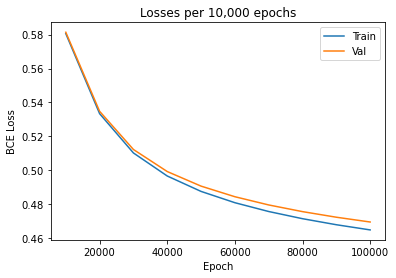

In [42]:
plt.plot(Iterations, losses, label='Train')
plt.plot(Iterations, losses_val, label='Val')
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title('Losses per 10,000 epochs')
plt.legend()
plt.show()

# PyTorch: k-fold cross validation

In [43]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [44]:
X_train.shape

(8693, 27)

In [45]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

In [46]:
import torch.nn.functional as F

In [47]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(27, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = torch.sigmoid(x)
        return x

In [48]:
# Define the K-fold Cross Validator
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

dataset = torch.utils.data.TensorDataset(X_train, y_train)

loss_list = []
acc_list = []

# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=32,
                                               sampler=train_subsampler)
    valid_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=32, 
                                               sampler=test_subsampler)
    
    # Init the neural network
    simple_nn = SimpleNN()
    optimizer = torch.optim.Adam(simple_nn.parameters(), lr=0.01)
    error = nn.BCELoss()
    
    for epoch in range(300):
        with torch.no_grad():
            valid_loss = 0
            num_right = 0
            for tensor_x, tensor_y in valid_loader:
                tensor_x = tensor_x.float()
                tensor_y = tensor_y.float().reshape(-1, 1)
                output = simple_nn(tensor_x)
                loss = error(output, tensor_y)
                valid_loss += loss.item() * len(tensor_x)
                result = [1 if out >= 0.5 else 0 for out in output]
                num_right += np.sum(np.array(result) == tensor_y.numpy().reshape(-1))
            
            valid_loss = valid_loss / len(valid_loader.sampler.indices)
            valid_accuracy = num_right / len(valid_loader.sampler.indices)
        
            if epoch % 75 == 0:
                print('Valid Loss: {} Accuracy: {} Epoch:{}'.format(valid_loss, valid_accuracy, epoch))
    
        train_loss = 0
        num_right = 0
        for tensor_x, tensor_y in train_loader:
            tensor_x = tensor_x.float()
            tensor_y = tensor_y.float().reshape(-1, 1)
            optimizer.zero_grad()
            output = simple_nn(tensor_x)
            loss = error(output, tensor_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(tensor_x)
            result = [1 if out >= 0.5 else 0 for out in output]
            num_right += np.sum(np.array(result) == tensor_y.numpy().reshape(-1))
        
        train_loss = train_loss / len(train_loader.sampler.indices)
        accuracy = num_right / len(train_loader.sampler.indices)
    
        if epoch % 75 == 0:
            print('Loss: {} Accuracy: {} Epoch:{}'.format(train_loss, accuracy, epoch))
            
    loss_list.append(valid_loss)
    acc_list.append(valid_accuracy)

    print('Training Ended')
print('Average Loss: {} Average Accuracy: {}'.format(np.mean(loss_list), np.mean(acc_list)))  

FOLD 0
--------------------------------
Valid Loss: 0.69579331390881 Accuracy: 0.4997124784358827 Epoch:0
Loss: 0.47472596301372827 Accuracy: 0.7880356629278114 Epoch:0
Valid Loss: 0.9497954713811539 Accuracy: 0.8073605520414031 Epoch:75
Loss: 0.3285336579729985 Accuracy: 0.8333333333333334 Epoch:75
Valid Loss: 1.1050724017167652 Accuracy: 0.8010350776308223 Epoch:150
Loss: 0.30938966476714985 Accuracy: 0.8528904227782571 Epoch:150
Valid Loss: 2.0251496825206545 Accuracy: 0.7849338700402531 Epoch:225
Loss: 0.4333201585734477 Accuracy: 0.8554788610871441 Epoch:225
Training Ended
FOLD 1
--------------------------------
Valid Loss: 0.6927024394085244 Accuracy: 0.503737780333525 Epoch:0
Loss: 0.45070955362133436 Accuracy: 0.7844406097210239 Epoch:0
Valid Loss: 0.642926930507207 Accuracy: 0.7947096032202415 Epoch:75
Loss: 0.31390452354949266 Accuracy: 0.8449813057233247 Epoch:75
Valid Loss: 0.891424203583946 Accuracy: 0.7889591719378953 Epoch:150
Loss: 0.4314348971514583 Accuracy: 0.8285878

# Conclusions:
    1. XGBoost, CatBoost and LGBM classifiers gives accuracy on validation set about 81%
    2. Hyperparameters tuning with Optuna improve the results to 81,5% (LGBM)
    3. Pytorch logistic regression gives accuracy on validation set about 77%
    4. Pytorch K-fold cross validation gives average accuracy on validation set about 78%